In [1]:
import numpy as np; from matplotlib import pyplot as plt; import pyross

# 1. Define model
M  = 2               # the population has two age groups
N  =  5e4            # and this is the total population
# exact parameters of reference trajectory
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # self-isolation of symtomatic infectives
# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0) # initial number of susceptibles
# set the contact matrix
C = np.array([[18., 9.], [3., 12.]])
contactMatrix = lambda t: C



In [2]:
# 2. Use pyross stochastic to generate reference trajectory
Tf = 100; Nf = Tf+1 # reference trajectory is 100 days long
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']




In [3]:
# 3. Run inference on the first 20 days
Tf_inf = 20; Nf_inf = Tf_inf + 1; data_inf = (data_array/N)[:Nf_inf]
# parameters for inference
eps = 1e-4; ftol = 1e-6; steps = 101
# initial guesses, bounds, and initial standard deviation for solver
alpha_g = 0.3; beta_g = 0.1; gIa_g = 0.14; gIs_g = 0.2
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)])
stds = np.array([0.2, 0.1, 0.05, 0.1])
# initialise solver and run minimisation
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
params = estimator.inference(guess, stds, data_inf, Tf_inf, Nf_inf,
                contactMatrix,bounds=bounds, global_max_iter=10,
            eps=eps, global_ftol_factor=1e3, ftol=ftol, verbose=False)
print('Best guess for parameters: {0}'.format(params))
# for forecasting we also need the covariance matrix
hess = estimator.hessian(params, guess, stds,
                        data_inf, Tf_inf, Nf_inf,contactMatrix)
cov = np.linalg.inv(hess)



(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=212300, Sun May 10 20:56:16 2020)
Best guess for parameters: [0.18638278 0.02026724 0.13345317 0.14496736]


In [4]:
# 4. Run forecast using inferred parameters and their covariance
parameters = {'alpha': params[0], 'beta': params[1],
              'gIa': params[2], 'gIs': params[3],'fsa':fsa,'cov':cov}
model_forecast = pyross.forecast.SIR(parameters, M, Ni)
# initial condition for forecast is final state from inference
S0_fc = data_inf[-1,:M]*N; Ia0_fc = data_inf[-1,M:2*M]*N
Is0_fc = data_inf[-1,2*M:]*N
Tf_fc = Tf - Tf_inf; Nf_fc = Tf_fc+1 # simulation time for forecast
Ns = 500 # number of forecasting samples
result_fc = model_forecast.simulate(S0_fc, Ia0_fc, Is0_fc,
                                contactMatrix, Tf_fc, Nf_fc,Ns=Ns)
trajectories_fc = result_fc['X']; t_fc = result_fc['t'] + Tf_inf




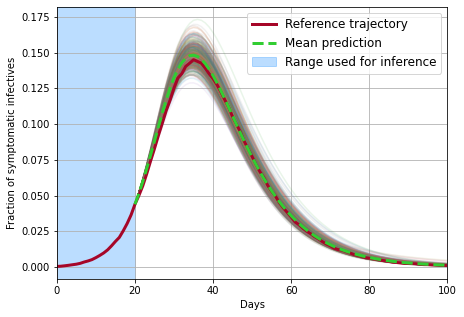

In [5]:

# 5. Visualise result: Plot fraction of symptomatic infectives
traj_ref = np.sum(data_array[:,2*M:],axis=-1) # reference trajectory
trajs_fc = np.sum(trajectories_fc[:,2*M:],axis=1) # predictions
mean_fc = np.mean( trajs_fc, axis=0) # mean prediction
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inf,label='Range used for inference',
           alpha=0.3,color='dodgerblue')
for i,e in enumerate(trajs_fc): # plot all forecasting trajectories
    ax.plot(t_fc,e/N,alpha=0.1)
ax.plot(traj_ref/N,lw=3,color='#A60628',label='Reference trajectory')
ax.plot(t_fc,mean_fc/N,
        ls='--',color='limegreen',label='Mean prediction',lw=3)
ax.set_xlim(0,np.max(t_fc)); ax.set_xlabel(r'Days')
ax.set_ylabel('Fraction of symptomatic infectives')
ax.legend(loc='upper right',fontsize=12)
plt.grid(); plt.show(fig); plt.close(fig)

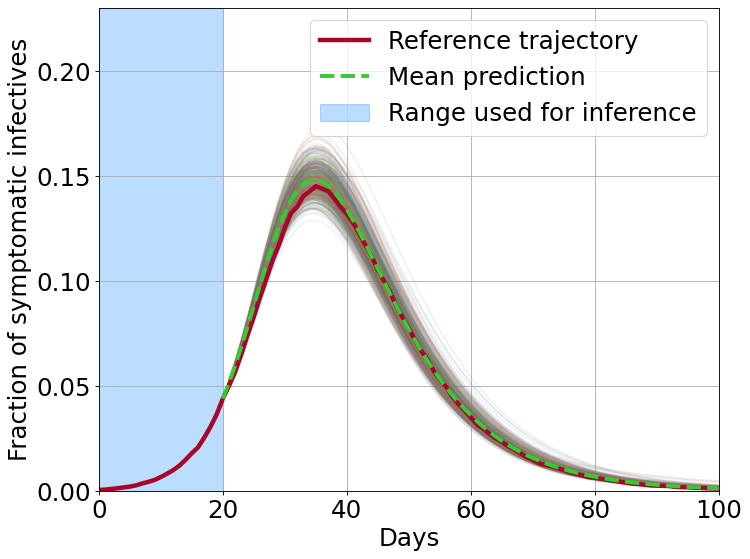

In [6]:
plt.rcParams.update({'font.size': 22})


# 5. Visualise result: Plot fraction of symptomatic infectives
traj_ref = np.sum(data_array[:,2*M:],axis=-1) # reference trajectory
trajs_fc = np.sum(trajectories_fc[:,2*M:],axis=1) # predictions
mean_fc = np.mean( trajs_fc, axis=0) # mean prediction
fig,ax = plt.subplots(1,1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
ax.axvspan(0, Tf_inf,label='Range used for inference',
           alpha=0.3,color='dodgerblue')
for i,e in enumerate(trajs_fc): # plot all forecasting trajectories
    ax.plot(t_fc,e/N,alpha=0.1)
ax.plot(traj_ref/N,lw=4,color='#A60628',label='Reference trajectory')
ax.plot(t_fc,mean_fc/N,
        ls='--',color='limegreen',label='Mean prediction',lw=3.5)
ax.set_xlim(0,np.max(t_fc)); ax.set_xlabel(r'Days')
plt.legend(fontsize=22,loc='upper right'); plt.grid() 
ax.set_ylim(0,0.23)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylabel('Fraction of symptomatic infectives')
fig.savefig('inference_and_forecasting.pdf',bbox_inches='tight')
plt.show(fig); plt.close(fig)